# KPI Forecasting in Cell Level using Holt-Winters Method

### About this notebook: 
Notebook prepared by Rini Apriyanti Purba. This work is offered for XL Axiata Planning Team to support Capacity Planning.

Summary:
This notebook aim to show a practical case of forecasting the KPIs in cell level by using the holt-winters methodology and define the ladders based on XL capacity planning team framework for Lebaran. Another purpose related to KPI forecasting (Payload and User) can use this template. For other KPIs and any adjustment can be modified in current notebook.

## 1. Importing Modules

In [16]:
%matplotlib inline
%load_ext watermark
import os

import pandas as pd
from statsmodels.tsa.holtwinters import ExponentialSmoothing
import numpy as np
import datetime
import natsort
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error,mean_squared_error

The watermark extension is already loaded. To reload it, use:
  %reload_ext watermark


In [20]:
print(' Reproducibility conditions for this notebook '.center(85,'-'))
%watermark -n -t -v -m -p numpy,scipy,matplotlib,pandas,sklearn,statsmodels,tensorflow,keras,arch
print('-'*85)

-------------------- Reproducibility conditions for this notebook -------------------
Python implementation: CPython
Python version       : 3.9.7
IPython version      : 7.29.0

numpy      : 1.20.3
scipy      : 1.7.1
matplotlib : 3.4.3
pandas     : 1.4.3
sklearn    : 1.1.1
statsmodels: 0.12.2
tensorflow : 2.7.0
keras      : 2.7.0
arch       : not installed

Compiler    : MSC v.1916 64 bit (AMD64)
OS          : Windows
Release     : 10
Machine     : AMD64
Processor   : Intel64 Family 6 Model 142 Stepping 12, GenuineIntel
CPU cores   : 8
Architecture: 64bit

-------------------------------------------------------------------------------------


## 2. Brief Methodology Description (Holt-Winters)

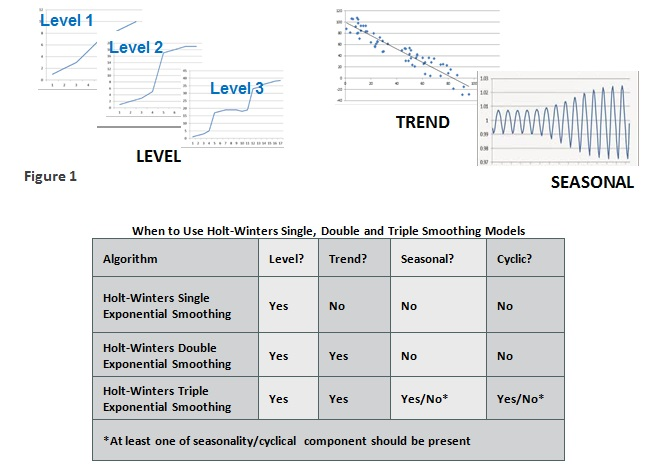

In [63]:
def create_columns(df):
    new_cols=[]
    mae=[]
    mse=[]
    for i in range(len(df.columns)):
        model = ExponentialSmoothing(df.iloc[:,i], trend="add", seasonal="add", seasonal_periods=52)
        fit = model.fit()
        pred = fit.forecast(52)
        df.fillna(0)
        pred.fillna(0)
        mae1=mean_absolute_error(df.iloc[0:52,i],pred)
        mse1=mean_squared_error(df.iloc[0:52,i],pred)
        new_cols.append(pred)
        mae.append(mae1)
        mse.append(mse1)    
    return new_cols, mae, mse, fit

def find_path(name, path):
    import os
    for root, dirs, files in os.walk(path):
        if name in files:
            return os.path.join(root, name)
        
def display_image(img_path):
    from IPython.display import Image
    return Image(filename = img_path, format = 'jpeg',  width = 1000, height = 10)


METHOD_IMAGE = 'holt-winters.jpg'
METHOD_PATH = r'C:\Users\eaprrin\OneDrive - Ericsson\Documents\Ericsson\Capacity Forecasting\Capacity_Forecasting 2023'

img_path = find_path(METHOD_IMAGE, METHOD_PATH)
display_image(img_path)

## 3. Dataset Processing

* KPI:
    1. Payload
    2. RRC Connected Users

* Data Used:
    - Y22-W02 until Y22-W53

* Basic Characteristic of Dataset

In [26]:
# Importing CSV Data for the Capacity (1 year data)
df=pd.read_csv("4G_Cell_Capacity_KPI_All_Week_2022_JABO_YOGYA_SLEMAN_V4.csv")
df.head(5)

Week Month  Year   Region     Area        Kabupaten     Kecamatan  \
0  Y22-W28  July  2022  CENTRAL  CENTRAL           SLEMAN        BERBAH   
1  Y22-W28  July  2022  CENTRAL  CENTRAL           SLEMAN        BERBAH   
2  Y22-W28  July  2022  CENTRAL  CENTRAL           SLEMAN        BERBAH   
3  Y22-W29  July  2022  CENTRAL  CENTRAL  KOTA YOGYAKARTA  GONDOKUSUMAN   
4  Y22-W29  July  2022  CENTRAL  CENTRAL           SLEMAN         DEPOK   

           TowerID         LTE Site_type  ... Cell_Availability  Payload_GB  \
0  JAW-YO-SMN-0302    4532286E     Macro  ...             100.0   18.307792   
1  JAW-YO-SMN-0302    4532286E     Macro  ...             100.0   49.022546   
2  JAW-YO-SMN-0302    4532286E     Macro  ...             100.0   64.089772   
3  JAW-YO-YYK-0527   453PC982E      Pico  ...             100.0    7.720998   
4  JAW-YO-SMN-0200  SH4534548E     Macro  ...             100.0    9.682059   

        DLUT  Cell_PDCP_DL_Thp_Mbps  LTE_RRC_Connected_Users  PRB_Utilz  \
0  14.268406              12.841113                13.780000  24.276196   
1   8.243889              10.780460                34.908611  55.435539   
2   5.572710              10.501663                46.781389  61.713571   
3   8.429685               8.044152                10.611667  10.975678   
4  12.586333               9.943323                15.117222  16.077455   

   Spectral Efficiency  LTE_Active_DL_Users_TTI  Payload_GB_BH  Week Date  
0                  NaN                 1.289676          1.580   7/4/2022  
1                  NaN                 2.275588          3.120   7/4/2022  
2                  NaN                 2.715534          3.195   7/4/2022  
3                  NaN                 1.096863          0.565  7/11/2022  
4             1.631015                 1.242205          0.850  7/11/2022  

[5 rows x 26 columns]

In [28]:
df = df[['Week','Week Date','Cellname','Payload_GB_BH','LTE_RRC_Connected_Users']]
df.fillna(method='ffill', inplace=True)
df.head(5)

C:\Users\eaprrin\AppData\Local\Temp/ipykernel_10836/125000060.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.fillna(method='ffill', inplace=True)


Week  Week Date             Cellname  Payload_GB_BH  \
0  Y22-W28   7/4/2022    YG4G18_4532286E_5          1.580   
1  Y22-W28   7/4/2022    YG4G18_4532286E_4          3.120   
2  Y22-W28   7/4/2022    YG4G18_4532286E_6          3.195   
3  Y22-W29  7/11/2022   YG4G18_453PC982E_4          0.565   
4  Y22-W29  7/11/2022  YG4G18_SH4534548E_5          0.850   

   LTE_RRC_Connected_Users  
0                13.780000  
1                34.908611  
2                46.781389  
3                10.611667  
4                15.117222

In [29]:
df.Week.unique()

array(['Y22-W28', 'Y22-W29', 'Y22-W25', 'Y22-W20', 'Y22-W23', 'Y22-W32',
       'Y22-W24', 'Y22-W03', 'Y22-W31', 'Y22-W27', 'Y22-W15', 'Y22-W26',
       'Y22-W21', 'Y22-W17', 'Y22-W18', 'Y22-W16', 'Y22-W02', 'Y22-W10',
       'Y22-W13', 'Y22-W14', 'Y22-W19', 'Y22-W22', 'Y22-W33', 'Y22-W12',
       'Y22-W11', 'Y22-W30', 'Y22-W34', 'Y22-W35', 'Y22-W43', 'Y22-W38',
       'Y22-W40', 'Y22-W41', 'Y22-W36', 'Y22-W04', 'Y22-W37', 'Y22-W42',
       'Y22-W44', 'Y22-W45', 'Y22-W39', 'Y22-W46', 'Y22-W48', 'Y22-W49',
       'Y22-W52', 'Y22-W05', 'Y22-W50', 'Y22-W53', 'Y22-W47', 'Y22-W07',
       'Y22-W08', 'Y22-W06', 'Y22-W09', 'Y22-W51'], dtype=object)

In [30]:
df2=df.groupby('Cellname').apply(lambda x: x.sort_values('Week', key=natsort.natsort_keygen(), ascending = True))

In [33]:
df2

Week   Week Date               Cellname  \
Cellname                                                                    
BD4G09_4410033E9_1    1104888  Y22-W02    1/3/2022     BD4G09_4410033E9_1   
                      1532245  Y22-W03   1/10/2022     BD4G09_4410033E9_1   
                      2960735  Y22-W04   1/17/2022     BD4G09_4410033E9_1   
                      3000201  Y22-W05   1/24/2022     BD4G09_4410033E9_1   
                      3314547  Y22-W06   1/31/2022     BD4G09_4410033E9_1   
...                                ...         ...                    ...   
YG4G21_SH4534555E21_7 1920413  Y22-W49  11/28/2022  YG4G21_SH4534555E21_7   
                      2575617  Y22-W50   12/5/2022  YG4G21_SH4534555E21_7   
                      3416551  Y22-W51  12/12/2022  YG4G21_SH4534555E21_7   
                      2670076  Y22-W52  12/19/2022  YG4G21_SH4534555E21_7   
                      1919979  Y22-W53  12/26/2022  YG4G21_SH4534555E21_7   

                               Payload_GB_BH  LTE_RRC_Connected_Users  
Cellname                                                               
BD4G09_4410033E9_1    1104888          0.345                21.065833  
                      1532245          0.306                21.289583  
                      2960735          1.355                17.857778  
                      3000201          0.580                 6.041111  
                      3314547          0.782                 6.579861  
...                                      ...                      ...  
YG4G21_SH4534555E21_7 1920413          3.110                49.054167  
                      2575617          3.038                53.334444  
                      3416551          2.974                42.538611  
                      2670076          1.348                21.532639  
                      1919979          1.970                28.129167  

[3451058 rows x 5 columns]

In [34]:
d = df2.reset_index(drop=True)
d

Week   Week Date               Cellname  Payload_GB_BH  \
0        Y22-W02    1/3/2022     BD4G09_4410033E9_1          0.345   
1        Y22-W03   1/10/2022     BD4G09_4410033E9_1          0.306   
2        Y22-W04   1/17/2022     BD4G09_4410033E9_1          1.355   
3        Y22-W05   1/24/2022     BD4G09_4410033E9_1          0.580   
4        Y22-W06   1/31/2022     BD4G09_4410033E9_1          0.782   
...          ...         ...                    ...            ...   
3451053  Y22-W49  11/28/2022  YG4G21_SH4534555E21_7          3.110   
3451054  Y22-W50   12/5/2022  YG4G21_SH4534555E21_7          3.038   
3451055  Y22-W51  12/12/2022  YG4G21_SH4534555E21_7          2.974   
3451056  Y22-W52  12/19/2022  YG4G21_SH4534555E21_7          1.348   
3451057  Y22-W53  12/26/2022  YG4G21_SH4534555E21_7          1.970   

         LTE_RRC_Connected_Users  
0                      21.065833  
1                      21.289583  
2                      17.857778  
3                       6.041111  
4                       6.579861  
...                          ...  
3451053                49.054167  
3451054                53.334444  
3451055                42.538611  
3451056                21.532639  
3451057                28.129167  

[3451058 rows x 5 columns]

In [35]:
x = d.pivot_table(index='Week', columns='Cellname', values='Payload_GB_BH')
x1 = x.fillna(0)
x1.head(5)

Cellname  BD4G09_4410033E9_1  BD4G09_4410033E9_2  BD4G09_4410033E9_3  \
Week                                                                   
Y22-W02                0.345               0.174               1.086   
Y22-W03                0.306               0.255               1.290   
Y22-W04                1.355               0.260               0.928   
Y22-W05                0.580               0.450               0.358   
Y22-W06                0.782               0.524               0.450   

Cellname  BD4G09_4410083E9_1  BD4G09_4410083E9_2  BD4G09_4410083E9_3  \
Week                                                                   
Y22-W02                0.525               0.328               2.562   
Y22-W03                0.350               0.186               3.135   
Y22-W04                0.610               0.210               2.410   
Y22-W05                0.924               0.280               2.578   
Y22-W06                0.215               0.384               2.700   

Cellname  BD4G09_4410099E9_1  BD4G09_4410099E9_2  BD4G09_4410099E9_3  \
Week                                                                   
Y22-W02                2.148               2.235               2.945   
Y22-W03                1.960               1.898               3.080   
Y22-W04                1.870               2.100               2.865   
Y22-W05                1.935               2.008               2.810   
Y22-W06                2.808               2.150               2.732   

Cellname  BD4G09_4410112E9_1  ...  YG4G21_MC4531724E21_9  \
Week                          ...                          
Y22-W02                1.210  ...                  9.770   
Y22-W03                1.620  ...                  5.175   
Y22-W04                1.824  ...                  4.638   
Y22-W05                2.235  ...                  5.052   
Y22-W06                2.425  ...                  7.590   

Cellname  YG4G21_MC4531729E21_18_M  YG4G21_MC4531729E21_7  \
Week                                                        
Y22-W02                        0.0                  7.642   
Y22-W03                        0.0                  7.125   
Y22-W04                        0.0                  7.778   
Y22-W05                        0.0                  7.836   
Y22-W06                        0.0                  9.060   

Cellname  YG4G21_MC4531729E21_8  YG4G21_MC4531729E21_9  YG4G21_MC4532981E21_7  \
Week                                                                            
Y22-W02                   7.875                  5.900                  0.456   
Y22-W03                   8.625                  6.520                  0.590   
Y22-W04                   8.630                  6.995                  0.344   
Y22-W05                   7.960                  6.292                  0.850   
Y22-W06                   7.924                  5.720                  1.480   

Cellname  YG4G21_MC4532981E21_8  YG4G21_MC4532981E21_9  YG4G21_SH4534547E21_7  \
Week                                                                            
Y22-W02                   0.592                  0.492                  0.722   
Y22-W03                   0.690                  1.022                  0.896   
Y22-W04                   0.484                  1.135                  0.564   
Y22-W05                   0.514                  0.850                  1.255   
Y22-W06                   1.060                  2.720                  0.400   

Cellname  YG4G21_SH4534555E21_7  
Week                             
Y22-W02                     0.0  
Y22-W03                     0.0  
Y22-W04                     0.0  
Y22-W05                     0.0  
Y22-W06                     0.0  

[5 rows x 71270 columns]

In [36]:
np.any(np.isnan(x1))

False

### Basic characteristics of the Dataset

In [54]:
def seasonal_decomposition(df):
    from statsmodels.tsa.seasonal import STL
    stl = STL(df, period=51)
    res = stl.fit()
    fig = res.plot()
    return fig

In [55]:
sample=x1.iloc[:,1]
sample.head(5)

Week
Y22-W02    0.174
Y22-W03    0.255
Y22-W04    0.260
Y22-W05    0.450
Y22-W06    0.524
Name: BD4G09_4410033E9_2, dtype: float64

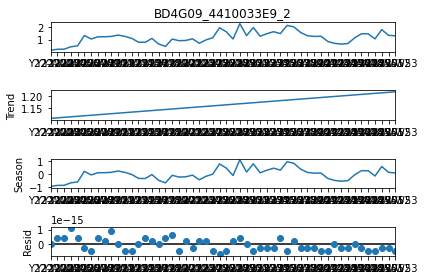

In [56]:
seasonal_decomposition(sample);

## 4. Forecasting

### Payload_GB_BH Forecast

This code below is the application of Holt-Winters Method Function that we have implemented in section 2 into existing Dataset that we have processed.

In [64]:
import warnings
warnings.filterwarnings('ignore')
payload_f=create_columns(x1)

In [65]:
payload_f

([52     2.581829
  53     2.414477
  54     2.289540
  55     2.192082
  56     2.349685
  57     2.466142
  58     2.789639
  59     2.086623
  60     2.674179
  61     2.483077
  62     2.316495
  63     2.517008
  64     1.919415
  65     1.949427
  66     1.680419
  67     1.861873
  68     2.146733
  69     1.856649
  70     1.982114
  71     2.719080
  72     2.429022
  73     2.287069
  74     2.311161
  75     2.304820
  76     2.564911
  77     3.249739
  78     3.082388
  79     2.957450
  80     2.859993
  81     3.017595
  82     3.134052
  83     3.457549
  84     2.754533
  85     3.342089
  86     3.150988
  87     2.984405
  88     3.184919
  89     2.587325
  90     2.617337
  91     2.348330
  92     2.529783
  93     2.814643
  94     2.524559
  95     2.650025
  96     3.386991
  97     3.096932
  98     2.954980
  99     2.979071
  100    2.972731
  101    3.232822
  102    3.917650
  103    3.750298
  dtype: float64,
  52     1.160091
  53     1.847680
  54     1

In [73]:
payload_f[3]

In [74]:
payload_f[3].summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                        ExponentialSmoothing Model Results                       
=================================================================================
Dep. Variable:     YG4G21_SH4534555E21_7   No. Observations:                   52
Model:              ExponentialSmoothing   SSE                              6.648
Optimized:                          True   AIC                            -48.957
Trend:                          Additive   BIC                              7.629
Seasonal:                       Additive   AICC                            50.243
Seasonal Periods:                     25   Date:                 Wed, 22 Feb 2023
Box-Cox:                           False   Time:                         06:35:30
Box-Cox Coeff.:                     None                                         
=================================================================================
                          coeff                 code              optimized      
---------------------------------------------------------------------------------
smoothing_level               1.0000000                alpha                 True
smoothing_trend                0.000000                 beta                 True
smoothing_seasonal           1.3633e-08                gamma                 True
initial_level                 0.4759791                  l.0                 True
initial_trend                 0.0352519                  b.0                 True
initial_seasons.0            -0.5114605                  s.0                 True
initial_seasons.1            -0.3394862                  s.1                 True
initial_seasons.2            -0.3748365                  s.2                 True
initial_seasons.3            -0.4101365                  s.3                 True
initial_seasons.4            -0.4454027                  s.4                 True
initial_seasons.5            -0.4806531                  s.5                 True
initial_seasons.6            -0.5158950                  s.6                 True
initial_seasons.7            -0.5511278                  s.7                 True
initial_seasons.8            -0.5863781                  s.8                 True
initial_seasons.9            -0.6215901                  s.9                 True
initial_seasons.10           -0.6567456                 s.10                 True
initial_seasons.11           -0.6918300                 s.11                 True
initial_seasons.12           -0.7268947                 s.12                 True
initial_seasons.13           -0.7620012                 s.13                 True
initial_seasons.14           -0.7971661                 s.14                 True
initial_seasons.15           -0.8323960                 s.15                 True
initial_seasons.16           -0.8676375                 s.16                 True
initial_seasons.17           -0.9028542                 s.17                 True
initial_seasons.18           -0.9380449                 s.18                 True
initial_seasons.19           -0.9732398                 s.19                 True
initial_seasons.20           -0.4010018                 s.20                 True
initial_seasons.21            0.9631538                 s.21                 True
initial_seasons.22            0.4757324                 s.22                 True
initial_seasons.23            0.4042883                 s.23                 True
initial_seasons.24            0.3368870                 s.24                 True
---------------------------------------------------------------------------------
"""

In [75]:
df_payload=pd.DataFrame(payload_f[0])
df_payload

52        53        54        55        56        57        58   \
0      2.581829  2.414477  2.289540  2.192082  2.349685  2.466142  2.789639   
1      1.160091  1.847680  1.424733  2.137206  1.665253  1.847528  1.924932   
2      2.117489  1.834955  1.895900  2.164828  2.103312  2.103303  2.181321   
3      2.510902  2.445365  2.237911  1.766939  1.943459  1.873525  2.011501   
4      0.154581  0.112089  0.097062  0.329533  0.201002 -0.139054 -0.125046   
...         ...       ...       ...       ...       ...       ...       ...   
71265  4.287406  4.605005  6.283111  7.234228  9.146246  9.104291  7.974721   
71266  4.917515  5.142550  4.652500  4.763043  5.578045  5.883515  5.808020   
71267  5.260061  6.367553  8.115065  7.362128  6.934166  7.378653  7.375086   
71268  1.425036  1.549548  1.140012  1.332645  1.438955  1.134962  1.218490   
71269  1.969902  1.969854  1.969839  1.969841  1.969851  1.969870  1.969872   

            59        60        61   ...        94         95         96   \
0      2.086623  2.674179  2.483077  ...   2.524559   2.650025   3.386991   
1      1.868931  2.238301  2.126191  ...   1.908324   2.139847   2.359890   
2      2.140323  2.289330  2.235368  ...   2.227816   2.303863   2.465401   
3      2.095975  1.953510  2.076044  ...   2.678434   2.760938   2.985961   
4     -0.061821 -0.108058 -0.050049  ...  -0.080614  -0.139621  -0.087596   
...         ...       ...       ...  ...        ...        ...        ...   
71265  8.920628  9.159186  9.064229  ...  12.504676  11.887249  11.975227   
71266  6.148006  6.866990  6.188470  ...  11.813619   9.499523   8.382017   
71267  7.150516  8.735118  8.202115  ...  11.562602  11.368150  10.265120   
71268  1.159773  1.419025  1.424999  ...   2.750855   2.359022   2.569443   
71269  1.969912  1.970008  1.970176  ...   2.852080   3.459570   4.858977   

             97         98         99         100        101        102  \
0       3.096932   2.954980   2.979071   2.972731   3.232822   3.917650   
1       2.182470   2.118383   2.561959   2.667161   2.576470   2.345776   
2       2.352400   2.819434   2.487473   2.458943   2.946911   2.804401   
3       2.990990   2.865969   2.770991   3.571849   3.477217   4.080896   
4      -0.075605  -0.068082  -0.142116  -0.087086  -0.097429  -0.052848   
...          ...        ...        ...        ...        ...        ...   
71265  11.197204  11.838228  10.997288  11.028053   9.574131   9.374271   
71266   9.913496  10.482532   9.827397   9.244064   9.430360   9.261586   
71267  11.795167  11.961674  12.312027  11.586669  10.680582  10.417976   
71268   1.862887   1.784882   1.308922   1.707959   2.084658   1.917694   
71269   4.406808   4.370616   4.338466   3.525371   3.732597   3.732499   

             103  
0       3.750298  
1       3.033364  
2       2.521867  
3       4.015359  
4      -0.095340  
...          ...  
71265   9.691870  
71266   9.486620  
71267  11.525468  
71268   2.042206  
71269   3.732451  

[71270 rows x 52 columns]

In [78]:
week=pd.read_csv("Week_convert.csv")
dict1=week.set_index('Code').to_dict()
week_dict = dict1.get('Week')

df_payload.rename(columns=week_dict,
          inplace=True)

In [79]:
df_payload

Y23-W01   Y23-W02   Y23-W03   Y23-W04   Y23-W05   Y23-W06   Y23-W07  \
0      2.581829  2.414477  2.289540  2.192082  2.349685  2.466142  2.789639   
1      1.160091  1.847680  1.424733  2.137206  1.665253  1.847528  1.924932   
2      2.117489  1.834955  1.895900  2.164828  2.103312  2.103303  2.181321   
3      2.510902  2.445365  2.237911  1.766939  1.943459  1.873525  2.011501   
4      0.154581  0.112089  0.097062  0.329533  0.201002 -0.139054 -0.125046   
...         ...       ...       ...       ...       ...       ...       ...   
71265  4.287406  4.605005  6.283111  7.234228  9.146246  9.104291  7.974721   
71266  4.917515  5.142550  4.652500  4.763043  5.578045  5.883515  5.808020   
71267  5.260061  6.367553  8.115065  7.362128  6.934166  7.378653  7.375086   
71268  1.425036  1.549548  1.140012  1.332645  1.438955  1.134962  1.218490   
71269  1.969902  1.969854  1.969839  1.969841  1.969851  1.969870  1.969872   

        Y23-W08   Y23-W09   Y23-W10  ...    Y23-W43    Y23-W44    Y23-W45  \
0      2.086623  2.674179  2.483077  ...   2.524559   2.650025   3.386991   
1      1.868931  2.238301  2.126191  ...   1.908324   2.139847   2.359890   
2      2.140323  2.289330  2.235368  ...   2.227816   2.303863   2.465401   
3      2.095975  1.953510  2.076044  ...   2.678434   2.760938   2.985961   
4     -0.061821 -0.108058 -0.050049  ...  -0.080614  -0.139621  -0.087596   
...         ...       ...       ...  ...        ...        ...        ...   
71265  8.920628  9.159186  9.064229  ...  12.504676  11.887249  11.975227   
71266  6.148006  6.866990  6.188470  ...  11.813619   9.499523   8.382017   
71267  7.150516  8.735118  8.202115  ...  11.562602  11.368150  10.265120   
71268  1.159773  1.419025  1.424999  ...   2.750855   2.359022   2.569443   
71269  1.969912  1.970008  1.970176  ...   2.852080   3.459570   4.858977   

         Y23-W46    Y23-W47    Y23-W48    Y23-W49    Y23-W50    Y23-W51  \
0       3.096932   2.954980   2.979071   2.972731   3.232822   3.917650   
1       2.182470   2.118383   2.561959   2.667161   2.576470   2.345776   
2       2.352400   2.819434   2.487473   2.458943   2.946911   2.804401   
3       2.990990   2.865969   2.770991   3.571849   3.477217   4.080896   
4      -0.075605  -0.068082  -0.142116  -0.087086  -0.097429  -0.052848   
...          ...        ...        ...        ...        ...        ...   
71265  11.197204  11.838228  10.997288  11.028053   9.574131   9.374271   
71266   9.913496  10.482532   9.827397   9.244064   9.430360   9.261586   
71267  11.795167  11.961674  12.312027  11.586669  10.680582  10.417976   
71268   1.862887   1.784882   1.308922   1.707959   2.084658   1.917694   
71269   4.406808   4.370616   4.338466   3.525371   3.732597   3.732499   

         Y23-W52  
0       3.750298  
1       3.033364  
2       2.521867  
3       4.015359  
4      -0.095340  
...          ...  
71265   9.691870  
71266   9.486620  
71267  11.525468  
71268   2.042206  
71269   3.732451  

[71270 rows x 52 columns]

In [80]:
x2=x1.T
x2

Week                   Y22-W02  Y22-W03  Y22-W04  Y22-W05  Y22-W06  Y22-W07  \
Cellname                                                                      
BD4G09_4410033E9_1       0.345    0.306    1.355    0.580    0.782    1.295   
BD4G09_4410033E9_2       0.174    0.255    0.260    0.450    0.524    1.325   
BD4G09_4410033E9_3       1.086    1.290    0.928    0.358    0.450    0.980   
BD4G09_4410083E9_1       0.525    0.350    0.610    0.924    0.215    0.152   
BD4G09_4410083E9_2       0.328    0.186    0.210    0.280    0.384    0.585   
...                        ...      ...      ...      ...      ...      ...   
YG4G21_MC4532981E21_7    0.456    0.590    0.344    0.850    1.480    2.712   
YG4G21_MC4532981E21_8    0.592    0.690    0.484    0.514    1.060    0.480   
YG4G21_MC4532981E21_9    0.492    1.022    1.135    0.850    2.720    3.138   
YG4G21_SH4534547E21_7    0.722    0.896    0.564    1.255    0.400    0.528   
YG4G21_SH4534555E21_7    0.000    0.000    0.000    0.000    0.000    0.000   

Week                   Y22-W08  Y22-W09  Y22-W10  Y22-W11  ...  Y22-W44  \
Cellname                                                   ...            
BD4G09_4410033E9_1       1.755    2.065    1.880   1.2200  ...    0.565   
BD4G09_4410033E9_2       1.055    1.225    1.225   1.2580  ...    0.718   
BD4G09_4410033E9_3       0.965    0.880    1.065   0.8040  ...    0.665   
BD4G09_4410083E9_1       0.315    0.480    0.616   0.9500  ...    0.625   
BD4G09_4410083E9_2       0.548    0.010    0.006   0.0775  ...    0.170   
...                        ...      ...      ...      ...  ...      ...   
YG4G21_MC4532981E21_7    2.656    3.374    1.958   2.8300  ...    8.600   
YG4G21_MC4532981E21_8    0.860    1.138    1.625   1.0650  ...    6.082   
YG4G21_MC4532981E21_9    2.178    2.102    1.880   1.6860  ...    8.585   
YG4G21_SH4534547E21_7    0.530    0.400    0.335   0.3980  ...    2.174   
YG4G21_SH4534555E21_7    0.000    0.000    0.000   0.0000  ...    0.000   

Week                    Y22-W45  Y22-W46  Y22-W47  Y22-W48  Y22-W49  Y22-W50  \
Cellname                                                                       
BD4G09_4410033E9_1     1.025000   0.7700    0.780    1.510    1.000    1.036   
BD4G09_4410033E9_2     0.655000   0.7050    1.150    1.460    1.455    1.062   
BD4G09_4410033E9_3     0.496000   0.5740    0.678    0.845    0.715    1.455   
BD4G09_4410083E9_1     0.580000   0.5050    0.705    1.085    1.210    0.860   
BD4G09_4410083E9_2     0.066000   0.1020    0.068    0.068    0.130    0.082   
...                         ...      ...      ...      ...      ...      ...   
YG4G21_MC4532981E21_7  7.738000   9.2200    8.344    9.240    8.460    8.478   
YG4G21_MC4532981E21_8  6.212000   8.0920    5.876    5.054    5.114    5.825   
YG4G21_MC4532981E21_9  8.590000   6.2650    5.850    5.784    6.820    6.575   
YG4G21_SH4534547E21_7  2.803333   3.8575    2.864    2.708    1.568    1.562   
YG4G21_SH4534555E21_7  0.000000   0.0000    1.215    4.014    3.110    3.038   

Week                   Y22-W51  Y22-W52  Y22-W53  
Cellname                                          
BD4G09_4410033E9_1       0.980    1.475    1.950  
BD4G09_4410033E9_2       1.780    1.340    1.300  
BD4G09_4410033E9_3       1.135    1.054    2.260  
BD4G09_4410083E9_1       0.715    2.064    2.080  
BD4G09_4410083E9_2       0.055    0.035    0.110  
...                        ...      ...      ...  
YG4G21_MC4532981E21_7    7.340    6.470    4.218  
YG4G21_MC4532981E21_8    6.326    5.015    4.916  
YG4G21_MC4532981E21_9    6.232    6.564    5.720  
YG4G21_SH4534547E21_7    0.626    0.932    1.592  
YG4G21_SH4534555E21_7    2.974    1.348    1.970  

[71270 rows x 52 columns]

In [81]:
cols = x2.columns.to_list() + df_payload.columns.to_list()
dfs = [x2,df_payload]
df3 = np.concatenate(dfs, axis=1)  
df3 = pd.DataFrame(df3, columns=cols)

In [83]:
df3.head(5)

Y22-W02  Y22-W03  Y22-W04  Y22-W05  Y22-W06  Y22-W07  Y22-W08  Y22-W09  \
0    0.345    0.306    1.355    0.580    0.782    1.295    1.755    2.065   
1    0.174    0.255    0.260    0.450    0.524    1.325    1.055    1.225   
2    1.086    1.290    0.928    0.358    0.450    0.980    0.965    0.880   
3    0.525    0.350    0.610    0.924    0.215    0.152    0.315    0.480   
4    0.328    0.186    0.210    0.280    0.384    0.585    0.548    0.010   

   Y22-W10  Y22-W11  ...   Y23-W43   Y23-W44   Y23-W45   Y23-W46   Y23-W47  \
0    1.880   1.2200  ...  2.524559  2.650025  3.386991  3.096932  2.954980   
1    1.225   1.2580  ...  1.908324  2.139847  2.359890  2.182470  2.118383   
2    1.065   0.8040  ...  2.227816  2.303863  2.465401  2.352400  2.819434   
3    0.616   0.9500  ...  2.678434  2.760938  2.985961  2.990990  2.865969   
4    0.006   0.0775  ... -0.080614 -0.139621 -0.087596 -0.075605 -0.068082   

    Y23-W48   Y23-W49   Y23-W50   Y23-W51   Y23-W52  
0  2.979071  2.972731  3.232822  3.917650  3.750298  
1  2.561959  2.667161  2.576470  2.345776  3.033364  
2  2.487473  2.458943  2.946911  2.804401  2.521867  
3  2.770991  3.571849  3.477217  4.080896  4.015359  
4 -0.142116 -0.087086 -0.097429 -0.052848 -0.095340  

[5 rows x 104 columns]

In [85]:
df_cell=pd.DataFrame(x2.index)
df_cell.head(5)

Cellname
0  BD4G09_4410033E9_1
1  BD4G09_4410033E9_2
2  BD4G09_4410033E9_3
3  BD4G09_4410083E9_1
4  BD4G09_4410083E9_2

In [86]:
df3_new=pd.concat([df_cell, df3], axis=1)
df3_new.head(5)

Cellname  Y22-W02  Y22-W03  Y22-W04  Y22-W05  Y22-W06  Y22-W07  \
0  BD4G09_4410033E9_1    0.345    0.306    1.355    0.580    0.782    1.295   
1  BD4G09_4410033E9_2    0.174    0.255    0.260    0.450    0.524    1.325   
2  BD4G09_4410033E9_3    1.086    1.290    0.928    0.358    0.450    0.980   
3  BD4G09_4410083E9_1    0.525    0.350    0.610    0.924    0.215    0.152   
4  BD4G09_4410083E9_2    0.328    0.186    0.210    0.280    0.384    0.585   

   Y22-W08  Y22-W09  Y22-W10  ...   Y23-W43   Y23-W44   Y23-W45   Y23-W46  \
0    1.755    2.065    1.880  ...  2.524559  2.650025  3.386991  3.096932   
1    1.055    1.225    1.225  ...  1.908324  2.139847  2.359890  2.182470   
2    0.965    0.880    1.065  ...  2.227816  2.303863  2.465401  2.352400   
3    0.315    0.480    0.616  ...  2.678434  2.760938  2.985961  2.990990   
4    0.548    0.010    0.006  ... -0.080614 -0.139621 -0.087596 -0.075605   

    Y23-W47   Y23-W48   Y23-W49   Y23-W50   Y23-W51   Y23-W52  
0  2.954980  2.979071  2.972731  3.232822  3.917650  3.750298  
1  2.118383  2.561959  2.667161  2.576470  2.345776  3.033364  
2  2.819434  2.487473  2.458943  2.946911  2.804401  2.521867  
3  2.865969  2.770991  3.571849  3.477217  4.080896  4.015359  
4 -0.068082 -0.142116 -0.087086 -0.097429 -0.052848 -0.095340  

[5 rows x 105 columns]

In [87]:
df3_new.to_csv("forecasted_payload_22022023.csv", index=None)

### RRC Connected Users Forecast

In [88]:
y = d.pivot_table(index='Week', columns='Cellname', values='LTE_RRC_Connected_Users')
y1 = y.fillna(0)
y1.head(5)

Cellname  BD4G09_4410033E9_1  BD4G09_4410033E9_2  BD4G09_4410033E9_3  \
Week                                                                   
Y22-W02            21.065833           20.438889           18.352222   
Y22-W03            21.289583           18.873889           22.934722   
Y22-W04            17.857778           14.369722           14.501389   
Y22-W05             6.041111            4.767361            5.915000   
Y22-W06             6.579861            4.383333            5.984028   

Cellname  BD4G09_4410083E9_1  BD4G09_4410083E9_2  BD4G09_4410083E9_3  \
Week                                                                   
Y22-W02           105.505833            5.814169           34.608889   
Y22-W03           105.786111            3.804444           33.410556   
Y22-W04            95.924167            3.567222           34.765972   
Y22-W05           118.004722            4.604167           53.233333   
Y22-W06           125.696528            5.089907           60.786111   

Cellname  BD4G09_4410099E9_1  BD4G09_4410099E9_2  BD4G09_4410099E9_3  \
Week                                                                   
Y22-W02            42.272778           43.889722           45.820556   
Y22-W03            30.106667           29.395556           45.250185   
Y22-W04            27.351111           35.570833           36.696528   
Y22-W05            46.650000           35.361944           37.581389   
Y22-W06            48.633611           43.354167           38.881389   

Cellname  BD4G09_4410112E9_1  ...  YG4G21_MC4531724E21_9  \
Week                          ...                          
Y22-W02            11.983796  ...              71.137778   
Y22-W03            18.324306  ...              44.513333   
Y22-W04            19.223889  ...              34.682222   
Y22-W05            40.506403  ...              34.938517   
Y22-W06            28.266111  ...              47.616248   

Cellname  YG4G21_MC4531729E21_18_M  YG4G21_MC4531729E21_7  \
Week                                                        
Y22-W02                        0.0              70.984722   
Y22-W03                        0.0              67.771389   
Y22-W04                        0.0              65.977222   
Y22-W05                        0.0              65.473889   
Y22-W06                        0.0              60.699444   

Cellname  YG4G21_MC4531729E21_8  YG4G21_MC4531729E21_9  YG4G21_MC4532981E21_7  \
Week                                                                            
Y22-W02               74.143056              46.532222               3.631944   
Y22-W03               89.224444              50.301944               3.680000   
Y22-W04               76.477222              50.816389               3.323333   
Y22-W05               69.258889              49.525833               5.890972   
Y22-W06               73.461944              48.152500               9.007222   

Cellname  YG4G21_MC4532981E21_8  YG4G21_MC4532981E21_9  YG4G21_SH4534547E21_7  \
Week                                                                            
Y22-W02                6.135417               5.938333               8.129167   
Y22-W03                6.523333               6.927083              10.187222   
Y22-W04                6.410417              12.418750               8.569167   
Y22-W05                5.712222               8.551389               7.073056   
Y22-W06                9.745833              18.630556               7.572778   

Cellname  YG4G21_SH4534555E21_7  
Week                             
Y22-W02                     0.0  
Y22-W03                     0.0  
Y22-W04                     0.0  
Y22-W05                     0.0  
Y22-W06                     0.0  

[5 rows x 71270 columns]

In [92]:
np.any(np.isnan(y1))

False

In [95]:
import warnings
warnings.filterwarnings('ignore')
from timeit import default_timer as timer

start = timer()

rrcuser_f=create_columns(y1)

end = timer()
print(end - start)

17478.02795650001


In [101]:
print("Time needed to run RRC Connected Users Forecast : %5.2f hours" % ((end-start)/3600))

Time needed to run RRC Connected Users Forecast :  4.86 hours


In [103]:
rrcuser_f[3].summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                        ExponentialSmoothing Model Results                       
=================================================================================
Dep. Variable:     YG4G21_SH4534555E21_7   No. Observations:                   52
Model:              ExponentialSmoothing   SSE                           3169.517
Optimized:                          True   AIC                            271.725
Trend:                          Additive   BIC                            328.311
Seasonal:                       Additive   AICC                           370.925
Seasonal Periods:                     25   Date:                 Thu, 23 Feb 2023
Box-Cox:                           False   Time:                         09:26:02
Box-Cox Coeff.:                     None                                         
=================================================================================
                          coeff                 code              optimized      
---------------------------------------------------------------------------------
smoothing_level               0.7971326                alpha                 True
smoothing_trend              1.4609e-07                 beta                 True
smoothing_seasonal           9.5205e-09                gamma                 True
initial_level                 6.9187364                  l.0                 True
initial_trend                 0.5193144                  b.0                 True
initial_seasons.0            -7.8782254                  s.0                 True
initial_seasons.1            -6.2002817                  s.1                 True
initial_seasons.2            -6.9185622                  s.2                 True
initial_seasons.3            -7.4407534                  s.3                 True
initial_seasons.4            -7.9606576                  s.4                 True
initial_seasons.5            -8.4791811                  s.5                 True
initial_seasons.6            -9.0017712                  s.6                 True
initial_seasons.7            -9.5221928                  s.7                 True
initial_seasons.8            -10.041752                  s.8                 True
initial_seasons.9            -10.559959                  s.9                 True
initial_seasons.10           -11.078892                 s.10                 True
initial_seasons.11           -11.597837                 s.11                 True
initial_seasons.12           -12.117230                 s.12                 True
initial_seasons.13           -12.635721                 s.13                 True
initial_seasons.14           -13.159515                 s.14                 True
initial_seasons.15           -13.676183                 s.15                 True
initial_seasons.16           -14.195155                 s.16                 True
initial_seasons.17           -14.713977                 s.17                 True
initial_seasons.18           -15.229702                 s.18                 True
initial_seasons.19           -15.747863                 s.19                 True
initial_seasons.20           -6.2844263                 s.20                 True
initial_seasons.21            25.751862                 s.21                 True
initial_seasons.22            7.2204169                 s.22                 True
initial_seasons.23            8.8413876                 s.23                 True
initial_seasons.24            2.9238768                 s.24                 True
---------------------------------------------------------------------------------
"""

In [105]:
df_user=pd.DataFrame(rrcuser_f[0])
df_user.rename(columns=week_dict,
          inplace=True)
df_user

Y23-W01    Y23-W02    Y23-W03    Y23-W04    Y23-W05    Y23-W06  \
0       9.173447   4.576967   4.013963   4.819429   5.347095   5.006124   
1      10.098137  13.093276  12.823832  12.218970  11.804526  12.121748   
2       5.013164   0.829324   1.053837   3.985496   3.710001   2.623399   
3     -14.968049 -12.825013 -16.359055 -17.521803 -11.771492  26.448304   
4       2.648098   2.244734   2.037576   5.129443   2.973106  -0.365115   
...          ...        ...        ...        ...        ...        ...   
71265  28.517891  31.398440  37.756082  49.157477  62.328848  65.752287   
71266  48.136867  47.477641  46.520386  45.485404  56.577556  58.322014   
71267  44.820225  56.087390  66.830078  75.408324  64.232798  71.779229   
71268  10.727735   8.219443   8.724615  14.087592  13.363035   8.368929   
71269  27.524265  27.521388  27.520798  27.521589  27.518314  27.517206   

         Y23-W07    Y23-W08    Y23-W09    Y23-W10  ...     Y23-W43  \
0       5.171178   5.591439   7.293618   4.781363  ...   -3.274130   
1      12.048415  11.287720  15.167581  13.743276  ...    5.965718   
2       3.721403   3.540248   4.290124   2.824263  ...   -5.895448   
3      21.441162   7.053263  -1.409170  31.220474  ...  -63.169292   
4      -0.344908  -0.174300  -0.498168   0.258544  ...   -0.503433   
...          ...        ...        ...        ...  ...         ...   
71265  59.695030  66.476792  65.203742  64.250395  ...   88.413928   
71266  58.637229  66.787096  75.753089  62.991802  ...   88.694866   
71267  76.271861  74.546655  82.757669  83.908869  ...  114.416097   
71268   9.591065  10.023345  12.927912  11.387662  ...   24.451052   
71269  27.516962  27.518069  27.518450  27.518820  ...   40.506170   

          Y23-W44     Y23-W45     Y23-W46     Y23-W47     Y23-W48     Y23-W49  \
0       -3.067062   -0.388703    0.051417   -0.200154    0.013179    2.696737   
1        5.707941    8.549746    9.376135    8.425996    9.803913    6.627107   
2       -4.670843   -4.655486   -4.494982   -4.780699   -4.169149   -4.367035   
3      -52.023604  -21.716066  -43.609830  -90.139973  -89.725111  -80.557132   
4       -1.179352   -1.152462   -0.982942   -1.113563   -1.253154   -0.500689   
...           ...         ...         ...         ...         ...         ...   
71265   84.569861   87.361175   82.978115   80.680713   78.772504   72.490523   
71266   96.500592   85.452792   91.314085   96.352554  103.507488   91.321725   
71267  117.379107  111.528602  115.547078  108.940022  116.494438  108.785365   
71268   19.830389   20.327089   14.981814   15.902405    9.548043   12.633759   
71269   50.488922   83.044524   65.032394   67.172679   61.774483   51.491695   

         Y23-W50     Y23-W51     Y23-W52  
0       4.358355    2.966268   -1.630212  
1      13.746356   10.419412   13.414550  
2      -2.401366   -6.346535  -10.530375  
3     -81.837369 -108.801988 -106.658952  
4       0.009780   -0.015742   -0.419106  
...          ...         ...         ...  
71265  64.601703   62.741390   65.621940  
71266  90.495949   90.467767   89.808541  
71267  98.028364   94.275494  105.542660  
71268  14.142786   12.979966   10.471673  
71269  53.688953   53.489987   53.487110  

[71270 rows x 52 columns]

In [108]:
y2=y1.T
cols = y2.columns.to_list() + df_user.columns.to_list()
dfs2 = [y2,df_user]
df4 = np.concatenate(dfs2, axis=1)  
df4 = pd.DataFrame(df4, columns=cols)
df4_new=pd.concat([df_cell, df4], axis=1)

In [112]:
df4_new.head(5)

Cellname     Y22-W02     Y22-W03    Y22-W04     Y22-W05  \
0  BD4G09_4410033E9_1   21.065833   21.289583  17.857778    6.041111   
1  BD4G09_4410033E9_2   20.438889   18.873889  14.369722    4.767361   
2  BD4G09_4410033E9_3   18.352222   22.934722  14.501389    5.915000   
3  BD4G09_4410083E9_1  105.505833  105.786111  95.924167  118.004722   
4  BD4G09_4410083E9_2    5.814169    3.804444   3.567222    4.604167   

      Y22-W06     Y22-W07     Y22-W08     Y22-W09     Y22-W10  ...    Y23-W43  \
0    6.579861   11.556250   12.663194   13.004861   12.468333  ...  -3.274130   
1    4.383333   10.205556    9.736806    9.126389    8.816111  ...   5.965718   
2    5.984028   12.605556   11.804861    9.862778   11.706250  ...  -5.895448   
3  125.696528  111.754399  130.202778  206.966667  136.947222  ... -63.169292   
4    5.089907    7.236581    6.172433    0.368056    0.416667  ...  -0.503433   

     Y23-W44    Y23-W45    Y23-W46    Y23-W47    Y23-W48    Y23-W49  \
0  -3.067062  -0.388703   0.051417  -0.200154   0.013179   2.696737   
1   5.707941   8.549746   9.376135   8.425996   9.803913   6.627107   
2  -4.670843  -4.655486  -4.494982  -4.780699  -4.169149  -4.367035   
3 -52.023604 -21.716066 -43.609830 -90.139973 -89.725111 -80.557132   
4  -1.179352  -1.152462  -0.982942  -1.113563  -1.253154  -0.500689   

     Y23-W50     Y23-W51     Y23-W52  
0   4.358355    2.966268   -1.630212  
1  13.746356   10.419412   13.414550  
2  -2.401366   -6.346535  -10.530375  
3 -81.837369 -108.801988 -106.658952  
4   0.009780   -0.015742   -0.419106  

[5 rows x 105 columns]

In [113]:
df4_new.to_csv("forecasted_rrcuser_22022023.csv", index=None)

In [5]:
df3_new=pd.read_csv("forecasted_payload_22022023.csv")
df4_new=pd.read_csv("forecasted_rrcuser_22022023.csv")

## 5. Visualization

df3_new : payload

df4_new : rrc_conn_users

In [6]:
df3_t=df3_new.T
df3_t

0                   1                   2      \
Cellname  BD4G09_4410033E9_1  BD4G09_4410033E9_2  BD4G09_4410033E9_3   
Y22-W02                0.345               0.174               1.086   
Y22-W03                0.306               0.255                1.29   
Y22-W04                1.355                0.26               0.928   
Y22-W05                 0.58                0.45               0.358   
...                      ...                 ...                 ...   
Y23-W48             2.979071            2.561959            2.487473   
Y23-W49             2.972731            2.667161            2.458943   
Y23-W50             3.232822             2.57647            2.946911   
Y23-W51              3.91765            2.345776            2.804401   
Y23-W52             3.750298            3.033364            2.521867   

                       3                   4                   5      \
Cellname  BD4G09_4410083E9_1  BD4G09_4410083E9_2  BD4G09_4410083E9_3   
Y22-W02                0.525               0.328               2.562   
Y22-W03                 0.35               0.186               3.135   
Y22-W04                 0.61                0.21                2.41   
Y22-W05                0.924                0.28               2.578   
...                      ...                 ...                 ...   
Y23-W48             2.770991           -0.142116           -0.595308   
Y23-W49             3.571849           -0.087086           -0.314749   
Y23-W50             3.477217           -0.097429           -0.121096   
Y23-W51             4.080896           -0.052848            -0.49077   
Y23-W52             4.015359            -0.09534            -0.45023   

                       6                   7                   8      \
Cellname  BD4G09_4410099E9_1  BD4G09_4410099E9_2  BD4G09_4410099E9_3   
Y22-W02                2.148               2.235               2.945   
Y22-W03                 1.96               1.898                3.08   
Y22-W04                 1.87                 2.1               2.865   
Y22-W05                1.935               2.008                2.81   
...                      ...                 ...                 ...   
Y23-W48             3.470699            1.944322            1.757833   
Y23-W49             3.703363            1.941916            1.807125   
Y23-W50             3.501694            1.649085            2.225131   
Y23-W51             4.428093            1.707164            1.845751   
Y23-W52             3.765044            1.296177            1.760177   

                       9      ...                  71260  \
Cellname  BD4G09_4410112E9_1  ...  YG4G21_MC4531724E21_9   
Y22-W02                 1.21  ...                   9.77   
Y22-W03                 1.62  ...                  5.175   
Y22-W04                1.824  ...                  4.638   
Y22-W05                2.235  ...                  5.052   
...                      ...  ...                    ...   
Y23-W48               7.2366  ...              12.663648   
Y23-W49             6.897446  ...              11.586355   
Y23-W50             6.971969  ...               7.248482   
Y23-W51             6.862632  ...               7.843581   
Y23-W52             7.040463  ...               9.278021   

                             71261                  71262  \
Cellname  YG4G21_MC4531729E21_18_M  YG4G21_MC4531729E21_7   
Y22-W02                        0.0                  7.642   
Y22-W03                        0.0                  7.125   
Y22-W04                        0.0                  7.778   
Y22-W05                        0.0                  7.836   
...                            ...                    ...   
Y23-W48                  21.683994              12.301517   
Y23-W49                  21.695224              10.312764   
Y23-W50                  22.152296              10.162356   
Y23-W51                  22.463721              10.636828   
Y23-W52                  22.768959  

In [7]:
new_header = df3_t.iloc[0] #grab the first row for the header
df3_t = df3_t[1:] #take the data less the header row
df3_t.columns = new_header #set the header row as the df header
df3_t

Cellname BD4G09_4410033E9_1 BD4G09_4410033E9_2 BD4G09_4410033E9_3  \
Y22-W02               0.345              0.174              1.086   
Y22-W03               0.306              0.255               1.29   
Y22-W04               1.355               0.26              0.928   
Y22-W05                0.58               0.45              0.358   
Y22-W06               0.782              0.524               0.45   
...                     ...                ...                ...   
Y23-W48            2.979071           2.561959           2.487473   
Y23-W49            2.972731           2.667161           2.458943   
Y23-W50            3.232822            2.57647           2.946911   
Y23-W51             3.91765           2.345776           2.804401   
Y23-W52            3.750298           3.033364           2.521867   

Cellname BD4G09_4410083E9_1 BD4G09_4410083E9_2 BD4G09_4410083E9_3  \
Y22-W02               0.525              0.328              2.562   
Y22-W03                0.35              0.186              3.135   
Y22-W04                0.61               0.21               2.41   
Y22-W05               0.924               0.28              2.578   
Y22-W06               0.215              0.384                2.7   
...                     ...                ...                ...   
Y23-W48            2.770991          -0.142116          -0.595308   
Y23-W49            3.571849          -0.087086          -0.314749   
Y23-W50            3.477217          -0.097429          -0.121096   
Y23-W51            4.080896          -0.052848           -0.49077   
Y23-W52            4.015359           -0.09534           -0.45023   

Cellname BD4G09_4410099E9_1 BD4G09_4410099E9_2 BD4G09_4410099E9_3  \
Y22-W02               2.148              2.235              2.945   
Y22-W03                1.96              1.898               3.08   
Y22-W04                1.87                2.1              2.865   
Y22-W05               1.935              2.008               2.81   
Y22-W06               2.808               2.15              2.732   
...                     ...                ...                ...   
Y23-W48            3.470699           1.944322           1.757833   
Y23-W49            3.703363           1.941916           1.807125   
Y23-W50            3.501694           1.649085           2.225131   
Y23-W51            4.428093           1.707164           1.845751   
Y23-W52            3.765044           1.296177           1.760177   

Cellname BD4G09_4410112E9_1  ... YG4G21_MC4531724E21_9  \
Y22-W02                1.21  ...                  9.77   
Y22-W03                1.62  ...                 5.175   
Y22-W04               1.824  ...                 4.638   
Y22-W05               2.235  ...                 5.052   
Y22-W06               2.425  ...                  7.59   
...                     ...  ...                   ...   
Y23-W48              7.2366  ...             12.663648   
Y23-W49            6.897446  ...             11.586355   
Y23-W50            6.971969  ...              7.248482   
Y23-W51            6.862632  ...              7.843581   
Y23-W52            7.040463  ...              9.278021   

Cellname YG4G21_MC4531729E21_18_M YG4G21_MC4531729E21_7 YG4G21_MC4531729E21_8  \
Y22-W02                       0.0                 7.642                 7.875   
Y22-W03                       0.0                 7.125                 8.625   
Y22-W04                       0.0                 7.778                  8.63   
Y22-W05                       0.0                 7.836                  7.96   
Y22-W06                       0.0                  9.06                 7.924   
...                           ...                   ...                   ...   
Y23-W48                 21.683994             12.301517             12.297071   
Y23-W49                 21.695224             10.312764             12.116253   
Y23-W50                 22.152296             10.162356              12.15095   
Y23-W5

In [8]:
df3_t2=df3_t.replace('', np.nan).set_index(df3_t.index).stack().reset_index(name='Payload_GB_BH')
df3_t2

level_0               Cellname Payload_GB_BH
0        Y22-W02     BD4G09_4410033E9_1         0.345
1        Y22-W02     BD4G09_4410033E9_2         0.174
2        Y22-W02     BD4G09_4410033E9_3         1.086
3        Y22-W02     BD4G09_4410083E9_1         0.525
4        Y22-W02     BD4G09_4410083E9_2         0.328
...          ...                    ...           ...
7412075  Y23-W52  YG4G21_MC4532981E21_7       9.69187
7412076  Y23-W52  YG4G21_MC4532981E21_8       9.48662
7412077  Y23-W52  YG4G21_MC4532981E21_9     11.525468
7412078  Y23-W52  YG4G21_SH4534547E21_7      2.042206
7412079  Y23-W52  YG4G21_SH4534555E21_7      3.732451

[7412080 rows x 3 columns]

In [9]:
df3_1=df3_t2[(df3_t2['Cellname'] == 'YG4G21_MC4532981E21_9')]

In [10]:
import plotly.express as px
x=df3_1.level_0
colors = ['Actual' if x < 'Y23-W01' else 'Forecast' for x in x]
fig=px.line(x=x, y=df3_1.Payload_GB_BH, color=colors, color_discrete_sequence=['blue', 'red'],
            labels=dict(x='Week', y='Payload_GB_BH'),
            title='YG4G21_MC4532981E21_9')
fig.show()

In [11]:
df4_t=df4_new.T
df4_t

0                   1                   2      \
Cellname  BD4G09_4410033E9_1  BD4G09_4410033E9_2  BD4G09_4410033E9_3   
Y22-W02            21.065833           20.438889           18.352222   
Y22-W03            21.289583           18.873889           22.934722   
Y22-W04            17.857778           14.369722           14.501389   
Y22-W05             6.041111            4.767361               5.915   
...                      ...                 ...                 ...   
Y23-W48             0.013179            9.803913           -4.169149   
Y23-W49             2.696737            6.627107           -4.367035   
Y23-W50             4.358355           13.746356           -2.401366   
Y23-W51             2.966268           10.419412           -6.346535   
Y23-W52            -1.630212            13.41455          -10.530375   

                       3                   4                   5      \
Cellname  BD4G09_4410083E9_1  BD4G09_4410083E9_2  BD4G09_4410083E9_3   
Y22-W02           105.505833            5.814169           34.608889   
Y22-W03           105.786111            3.804444           33.410556   
Y22-W04            95.924167            3.567222           34.765972   
Y22-W05           118.004722            4.604167           53.233333   
...                      ...                 ...                 ...   
Y23-W48           -89.725111           -1.253154          -16.757259   
Y23-W49           -80.557132           -0.500689          -16.425866   
Y23-W50           -81.837369             0.00978          -16.767352   
Y23-W51          -108.801988           -0.015742          -14.147894   
Y23-W52          -106.658952           -0.419106           -7.838035   

                       6                   7                   8      \
Cellname  BD4G09_4410099E9_1  BD4G09_4410099E9_2  BD4G09_4410099E9_3   
Y22-W02            42.272778           43.889722           45.820556   
Y22-W03            30.106667           29.395556           45.250185   
Y22-W04            27.351111           35.570833           36.696528   
Y22-W05                46.65           35.361944           37.581389   
...                      ...                 ...                 ...   
Y23-W48            60.638477            4.187221          -22.799835   
Y23-W49            71.466257           13.777678          -20.493634   
Y23-W50            62.693983            6.381731          -22.813361   
Y23-W51            61.214964            5.900887          -30.155197   
Y23-W52            72.586535            7.056805           -29.37465   

                       9      ...                  71260  \
Cellname  BD4G09_4410112E9_1  ...  YG4G21_MC4531724E21_9   
Y22-W02            11.983796  ...              71.137778   
Y22-W03            18.324306  ...              44.513333   
Y22-W04            19.223889  ...              34.682222   
Y22-W05            40.506403  ...              34.938517   
...                      ...  ...                    ...   
Y23-W48            58.863956  ...             -69.835183   
Y23-W49            55.172074  ...             -74.995389   
Y23-W50             60.81574  ...            -101.600357   
Y23-W51            55.752273  ...            -107.995558   
Y23-W52            72.828832  ...             -95.892388   

                             71261                  71262  \
Cellname  YG4G21_MC4531729E21_18_M  YG4G21_MC4531729E21_7   
Y22-W02                        0.0              70.984722   
Y22-W03                        0.0              67.771389   
Y22-W04                        0.0              65.977222   
Y22-W05                        0.0              65.473889   
...                            ...                    ...   
Y23-W48                  73.218326              96.525719   
Y23-W49                  74.285197             116.350084   
Y23-W50                   72.87485             110.417149   
Y23-W51                  72.926313             108.136339   
Y23-W52                  72.926275  

In [12]:
new_header = df4_t.iloc[0] #grab the first row for the header
df4_t = df4_t[1:] #take the data less the header row
df4_t.columns = new_header #set the header row as the df header
df4_t2=df4_t.replace('', np.nan).set_index(df4_t.index).stack().reset_index(name='LTE_RRC_Connected_Users')
df4_t2

level_0               Cellname LTE_RRC_Connected_Users
0        Y22-W02     BD4G09_4410033E9_1               21.065833
1        Y22-W02     BD4G09_4410033E9_2               20.438889
2        Y22-W02     BD4G09_4410033E9_3               18.352222
3        Y22-W02     BD4G09_4410083E9_1              105.505833
4        Y22-W02     BD4G09_4410083E9_2                5.814169
...          ...                    ...                     ...
7412075  Y23-W52  YG4G21_MC4532981E21_7                65.62194
7412076  Y23-W52  YG4G21_MC4532981E21_8               89.808541
7412077  Y23-W52  YG4G21_MC4532981E21_9               105.54266
7412078  Y23-W52  YG4G21_SH4534547E21_7               10.471673
7412079  Y23-W52  YG4G21_SH4534555E21_7                53.48711

[7412080 rows x 3 columns]

In [13]:
df4_1=df4_t2[(df4_t2['Cellname'] == 'YG4G21_MC4532981E21_9')]
df4_1.head(5)

level_0               Cellname LTE_RRC_Connected_Users
71267   Y22-W02  YG4G21_MC4532981E21_9                5.938333
142537  Y22-W03  YG4G21_MC4532981E21_9                6.927083
213807  Y22-W04  YG4G21_MC4532981E21_9                12.41875
285077  Y22-W05  YG4G21_MC4532981E21_9                8.551389
356347  Y22-W06  YG4G21_MC4532981E21_9               18.630556

In [14]:
import plotly.express as px
x3=df4_1.level_0
colors = ['Actual' if x < 'Y23-W01' else 'Forecast' for x in x]
fig1=px.line(x=x3, y=df4_1.LTE_RRC_Connected_Users, color=colors, color_discrete_sequence=['blue', 'red'],
            labels=dict(x='Week', y='LTE_RRC_Connected_Users'),
            title='YG4G21_MC4532981E21_9')
fig1.show()

## 6. Capacity Planning

1. Convert the cell level forecast to sector level forecast by sum all values based on TowerID_Sector
2. Convert weeks to months (only the required period)
3. Lookup the result to EID Simplify
4. Define the forecast Capability for Payload and User
5. Define the Ladder and Upgrade Decision

In [63]:
#read input for reference cell sector
dataset=pd.read_csv("Cell Sector Reference W03 Jabodetabek_Jogja_Sleman_03022023 v01.csv")

C:\Users\eaprrin\AppData\Local\Temp/ipykernel_17848/1362959442.py:2: DtypeWarning:

Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.



In [65]:
dataset.rename(columns={'Cellname NQI W03':'Cellname'}, inplace=True)
dataset.head(5)

FunctionSite NQI W03  TowerID NQI W03 LTE NQI W03 Sector NQI W03  \
0  GUNUNG SUGIH CILEGON  JAW-BT-CLG-0002    4.48E+15              1   
1  GUNUNG SUGIH CILEGON  JAW-BT-CLG-0002    4.48E+15              2   
2  GUNUNG SUGIH CILEGON  JAW-BT-CLG-0002    4.48E+15              3   
3  GUNUNG SUGIH CILEGON  JAW-BT-CLG-0002    4483116E              3   
4  GUNUNG SUGIH CILEGON  JAW-BT-CLG-0002    4483116E              1   

  Site_type NQI W03 Site_layer NQI W03 MIMO NQI W03            Cellname  \
0             Macro               L900         2T2R  SR4G09_4483116E9_1   
1             Macro               L900         2T2R  SR4G09_4483116E9_2   
2             Macro               L900         2T2R  SR4G09_4483116E9_3   
3             Macro              L1800         2T2R  SR4G18_4483116E_16   
4             Macro              L1800         2T2R   SR4G18_4483116E_4   

    Site ID         Tower ID Site ID_Sector    Tower ID_Sector Sector Update  \
0  4483116E  JAW-BT-CLG-0002     4483116E_1  JAW-BT-CLG-0002_1             1   
1  4483116E  JAW-BT-CLG-0002     4483116E_2  JAW-BT-CLG-0002_2             2   
2  4483116E  JAW-BT-CLG-0002     4483116E_3  JAW-BT-CLG-0002_3             3   
3  4483116E  JAW-BT-CLG-0002     4483116E_4  JAW-BT-CLG-0002_4             4   
4  4483116E  JAW-BT-CLG-0002     4483116E_1  JAW-BT-CLG-0002_1             1   

  Layer System Update Site Type Update Traffic Remark W03 Clutter Type  \
0                L900            Macro       Have Traffic        Urban   
1                L900            Macro       Have Traffic        Urban   
2                L900            Macro       Have Traffic        Urban   
3               L1800            Macro       Have Traffic        Urban   
4               L1800            Macro       Have Traffic        Urban   

   Region  W03-2023_Payload_Capability_1BH  
0  JABO 2                        27.905273  
1  JABO 2                        27.905273  
2  JABO 2                        27.905273  
3  JABO 2                        27.905273  
4  JABO 2                        27.905273

In [66]:
merge1=df3_new.merge(dataset, on='Cellname', how='left')

In [67]:
merge1.head(5)

Cellname  Y22-W02  Y22-W03  Y22-W04  Y22-W05  Y22-W06  Y22-W07  \
0  BD4G09_4410033E9_1    0.345    0.306    1.355    0.580    0.782    1.295   
1  BD4G09_4410033E9_2    0.174    0.255    0.260    0.450    0.524    1.325   
2  BD4G09_4410033E9_3    1.086    1.290    0.928    0.358    0.450    0.980   
3  BD4G09_4410083E9_1    0.525    0.350    0.610    0.924    0.215    0.152   
4  BD4G09_4410083E9_2    0.328    0.186    0.210    0.280    0.384    0.585   

   Y22-W08  Y22-W09  Y22-W10  ...         Tower ID  Site ID_Sector  \
0    1.755    2.065    1.880  ...  JAW-JB-KWG-1910      4410033E_1   
1    1.055    1.225    1.225  ...  JAW-JB-KWG-1910      4410033E_2   
2    0.965    0.880    1.065  ...  JAW-JB-KWG-1910      4410033E_3   
3    0.315    0.480    0.616  ...  JAW-JB-KWG-1908      4410083E_1   
4    0.548    0.010    0.006  ...  JAW-JB-KWG-1908      4410083E_2   

     Tower ID_Sector  Sector Update  Layer System Update  Site Type Update  \
0  JAW-JB-KWG-1910_1              1                 L900             Macro   
1  JAW-JB-KWG-1910_2              2                 L900             Macro   
2  JAW-JB-KWG-1910_3              3                 L900             Macro   
3  JAW-JB-KWG-1908_1              1                 L900             Macro   
4  JAW-JB-KWG-1908_2              2                 L900             Macro   

   Traffic Remark W03  Clutter Type  Region  W03-2023_Payload_Capability_1BH  
0        Have Traffic      SubUrban  JABO 2                        27.905273  
1        Have Traffic      SubUrban  JABO 2                        27.905273  
2        Have Traffic      SubUrban  JABO 2                        27.905273  
3        Have Traffic      SubUrban  JABO 2                        27.905273  
4        Have Traffic      SubUrban  JABO 2                        27.905273  

[5 rows x 123 columns]

In [24]:
merge_pivot = merge1.groupby('Tower ID_Sector').sum()

In [25]:
merge_pivot.head(5)

Y22-W02  Y22-W03  Y22-W04  Y22-W05  Y22-W06  Y22-W07  \
Tower ID_Sector                                                           
-                  515.977  514.209  520.570  489.508  463.938  460.476   
JAW-BT-CLG-0002_1   19.056   17.585   20.304   19.751   18.342   19.122   
JAW-BT-CLG-0002_2    6.814    6.435    6.766    6.198    6.872   10.384   
JAW-BT-CLG-0002_3   12.716   12.818   12.674   13.389   13.178   14.514   
JAW-BT-CLG-0002_4   13.821   11.658   13.980   13.884   13.474   15.168   

                   Y22-W08  Y22-W09  Y22-W10   Y22-W11  ...     Y23-W44  \
Tower ID_Sector                                         ...               
-                  460.805  494.423  477.312  480.2545  ... -622.101309   
JAW-BT-CLG-0002_1   20.330   21.020   15.940   18.8440  ...   43.453383   
JAW-BT-CLG-0002_2   10.194    7.932    5.936    6.0820  ...   15.579610   
JAW-BT-CLG-0002_3   14.430   15.734   11.820   15.1020  ...   25.745074   
JAW-BT-CLG-0002_4   15.230   14.865   14.594   14.9020  ...   30.818044   

                      Y23-W45     Y23-W46     Y23-W47     Y23-W48     Y23-W49  \
Tower ID_Sector                                                                 
-                 -647.537337 -654.543943 -683.970268 -750.707694 -796.803353   
JAW-BT-CLG-0002_1   44.411934   44.024925   45.015690   45.744770   48.127890   
JAW-BT-CLG-0002_2   18.079697   23.349220   15.943630   15.053960   17.095218   
JAW-BT-CLG-0002_3   24.723140   25.223220   25.956267   25.578282   25.538952   
JAW-BT-CLG-0002_4   29.219098   32.118134   31.970064   31.742459   31.877371   

                      Y23-W50     Y23-W51     Y23-W52  \
Tower ID_Sector                                         
-                 -820.888326 -828.718862 -857.208281   
JAW-BT-CLG-0002_1   46.557947   49.601404   48.225425   
JAW-BT-CLG-0002_2   16.737551   18.679268   17.793748   
JAW-BT-CLG-0002_3   25.435572   25.415068   25.732664   
JAW-BT-CLG-0002_4   30.801299   31.806725   31.254532   

                   W03-2023_Payload_Capability_1BH  
Tower ID_Sector                                     
-                                      2851.391602  
JAW-BT-CLG-0002_1                        83.715820  
JAW-BT-CLG-0002_2                        83.715820  
JAW-BT-CLG-0002_3                        83.715820  
JAW-BT-CLG-0002_4                        55.810547  

[5 rows x 105 columns]

In [26]:
payload=merge_pivot.merge(dataset, on='Tower ID_Sector', how='left')

In [27]:
payload2=payload.drop_duplicates(subset='Tower ID_Sector')

In [28]:
payload2=payload2.tail(-1)
payload2.head(5)

Tower ID_Sector  Y22-W02  Y22-W03  Y22-W04  Y22-W05  Y22-W06  Y22-W07  \
176  JAW-BT-CLG-0002_1   19.056   17.585   20.304   19.751   18.342   19.122   
179  JAW-BT-CLG-0002_2    6.814    6.435    6.766    6.198    6.872   10.384   
182  JAW-BT-CLG-0002_3   12.716   12.818   12.674   13.389   13.178   14.514   
185  JAW-BT-CLG-0002_4   13.821   11.658   13.980   13.884   13.474   15.168   
187  JAW-BT-CLG-0003_1   11.064   12.250   14.880   13.602   11.650   10.825   

     Y22-W08  Y22-W09  Y22-W10  ...   Site ID         Tower ID  \
176   20.330   21.020   15.940  ...  4483116E  JAW-BT-CLG-0002   
179   10.194    7.932    5.936  ...  4483116E  JAW-BT-CLG-0002   
182   14.430   15.734   11.820  ...  4483116E  JAW-BT-CLG-0002   
185   15.230   14.865   14.594  ...  4483116E  JAW-BT-CLG-0002   
187   12.855   15.029   14.103  ...  4483192E  JAW-BT-CLG-0003   

     Site ID_Sector  Sector Update  Layer System Update  Site Type Update  \
176      4483116E_1              1                 L900             Macro   
179      4483116E_2              2                 L900             Macro   
182      4483116E_3              3                 L900             Macro   
185      4483116E_4              4                L1800             Macro   
187      4483192E_1              1                 L900             Macro   

     Traffic Remark W03  Clutter Type  Region  \
176        Have Traffic         Urban  JABO 2   
179        Have Traffic         Urban  JABO 2   
182        Have Traffic         Urban  JABO 2   
185        Have Traffic         Urban  JABO 2   
187        Have Traffic         Urban  JABO 2   

     W03-2023_Payload_Capability_1BH_y  
176                          27.905273  
179                          27.905273  
182                          27.905273  
185                          27.905273  
187                          27.905273  

[5 rows x 124 columns]

In [29]:
payload2['Jan-23-Payload'] =  payload2[['Y23-W01', 'Y23-W02','Y23-W03','Y23-W04']].sum(axis=1)
payload2['Feb-23-Payload'] =  payload2[['Y23-W05', 'Y23-W06','Y23-W07','Y23-W08']].sum(axis=1)
payload2['Mar-23-Payload'] =  payload2[['Y23-W09', 'Y23-W10','Y23-W11','Y23-W12','Y23-W13']].sum(axis=1)
payload2['Apr-23-Payload'] =  payload2[['Y23-W14', 'Y23-W15','Y23-W16','Y23-W17']].sum(axis=1)
payload2['May-23-Payload'] =  payload2[['Y23-W18', 'Y23-W19','Y23-W20','Y23-W21']].sum(axis=1)

In [35]:
payload2.to_csv("forecasted_payload_toweridsector_23022023.csv", index=None)

In [81]:
#automation of Week to Date - still ongoing
import datetime
week_date=[]
def weektodate(df):
    df = df.columns.to_list()
    r = [datetime.datetime.strptime(df + '-1', 'Y%y-W%U-%w')]
    week_date.append(r.date())
    return week_date

In [34]:
temp_payload=payload2[['Site ID_Sector', 'Tower ID_Sector', 'Sector Update', 'Site ID', 'Tower ID', 'Site Type Update', 'Traffic Remark W03', 'Clutter Type','Region', 'Jan-23-Payload', 'Feb-23-Payload', 'Mar-23-Payload', 'Apr-23-Payload', 'May-23-Payload']]

In [35]:
temp_payload

Site ID_Sector    Tower ID_Sector Sector Update   Site ID  \
176       4483116E_1  JAW-BT-CLG-0002_1             1  4483116E   
179       4483116E_2  JAW-BT-CLG-0002_2             2  4483116E   
182       4483116E_3  JAW-BT-CLG-0002_3             3  4483116E   
185       4483116E_4  JAW-BT-CLG-0002_4             4  4483116E   
187       4483192E_1  JAW-BT-CLG-0003_1             1  4483192E   
...              ...                ...           ...       ...   
70191     4533691E_2  JAW-YO-YYK-0684_2             2  4533691E   
70193     4533691E_3  JAW-YO-YYK-0684_3             3  4533691E   
70195     4533187E_1  JAW-YO-YYK-0685_1             1  4533187E   
70197     4533187E_2  JAW-YO-YYK-0685_2             2  4533187E   
70199     4533187E_3  JAW-YO-YYK-0685_3             3  4533187E   

              Tower ID Site Type Update Traffic Remark W03 Clutter Type  \
176    JAW-BT-CLG-0002            Macro       Have Traffic        Urban   
179    JAW-BT-CLG-0002            Macro       Have Traffic        Urban   
182    JAW-BT-CLG-0002            Macro       Have Traffic        Urban   
185    JAW-BT-CLG-0002            Macro       Have Traffic        Urban   
187    JAW-BT-CLG-0003            Macro       Have Traffic        Urban   
...                ...              ...                ...          ...   
70191  JAW-YO-YYK-0684            MACRO       Have Traffic        Rural   
70193  JAW-YO-YYK-0684            MACRO       Have Traffic        Rural   
70195  JAW-YO-YYK-0685            MACRO       Have Traffic        Urban   
70197  JAW-YO-YYK-0685            MACRO       Have Traffic        Urban   
70199  JAW-YO-YYK-0685            MACRO       Have Traffic        Urban   

             Region  Jan-23-Payload  Feb-23-Payload  Mar-23-Payload  \
176          JABO 2      130.707838      133.752202      166.881475   
179          JABO 2       51.585792       59.160634       77.217453   
182          JABO 2       76.402344       85.290831      104.111590   
185          JABO 2       88.710647       94.133681      121.080247   
187          JABO 2       69.683542       70.433616       87.172246   
...             ...             ...             ...             ...   
70191  CENTRAL JAVA       69.363765       70.629331       90.814736   
70193  CENTRAL JAVA       43.883373       45.825546       55.098288   
70195  CENTRAL JAVA       78.321131       79.585466       98.404880   
70197  CENTRAL JAVA       39.549369       39.662049       48.351904   
70199  CENTRAL JAVA       51.239450       53.918999       65.844194   

       Apr-23-Payload  May-23-Payload  
176        134.258386      145.796821  
179         49.219003       60.861260  
182         81.432092       86.234984  
185        101.708352      104.135867  
187         67.357437       67.321864  
...               ...             ...  
70191       70.197812       74.294703  
70193       44.307561       43.844683  
70195       84.176120       83.262512  
70197       35.165315       33.896678  
70199       51.285325       58.586174  

[24722 rows x 14 columns]

In [37]:
# create new column for target capability payload forecast
temp_payload['TARGET CAPABILITY PAYLOAD LEBARAN 2023 (FORECAST)'] = (1/0.7)*temp_payload['May-23-Payload']

C:\Users\eaprrin\AppData\Local\Temp/ipykernel_17848/38424021.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [38]:
temp_payload.head(5)

Site ID_Sector    Tower ID_Sector Sector Update   Site ID  \
176     4483116E_1  JAW-BT-CLG-0002_1             1  4483116E   
179     4483116E_2  JAW-BT-CLG-0002_2             2  4483116E   
182     4483116E_3  JAW-BT-CLG-0002_3             3  4483116E   
185     4483116E_4  JAW-BT-CLG-0002_4             4  4483116E   
187     4483192E_1  JAW-BT-CLG-0003_1             1  4483192E   

            Tower ID Site Type Update Traffic Remark W03 Clutter Type  Region  \
176  JAW-BT-CLG-0002            Macro       Have Traffic        Urban  JABO 2   
179  JAW-BT-CLG-0002            Macro       Have Traffic        Urban  JABO 2   
182  JAW-BT-CLG-0002            Macro       Have Traffic        Urban  JABO 2   
185  JAW-BT-CLG-0002            Macro       Have Traffic        Urban  JABO 2   
187  JAW-BT-CLG-0003            Macro       Have Traffic        Urban  JABO 2   

     Jan-23-Payload  Feb-23-Payload  Mar-23-Payload  Apr-23-Payload  \
176      130.707838      133.752202      166.881475      134.258386   
179       51.585792       59.160634       77.217453       49.219003   
182       76.402344       85.290831      104.111590       81.432092   
185       88.710647       94.133681      121.080247      101.708352   
187       69.683542       70.433616       87.172246       67.357437   

     May-23-Payload  TARGET CAPABILITY PAYLOAD LEBARAN 2023 (FORECAST)  
176      145.796821                                         208.281173  
179       60.861260                                          86.944658  
182       86.234984                                         123.192834  
185      104.135867                                         148.765525  
187       67.321864                                          96.174092

In [39]:
current=pd.read_csv('EID_Simplify_Capacity_Config_W03-2023_JABO+CJ.csv',encoding_errors= 'replace')

In [40]:
current=current[['TowerID_Sector','Region Sales','Kabupaten','Kecamatan','Site Name','W03-2023_Payload Capability 1BH']]

In [41]:
#rename temp_payload
temp_payload.rename(columns={'Tower ID_Sector':'TowerID_Sector'}, inplace=True)

C:\Users\eaprrin\AppData\Local\Temp/ipykernel_17848/2214447211.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [42]:
temp_payload=temp_payload.merge(current, on='TowerID_Sector', how='left')

In [45]:
temp_payload['TARGET CAPABILITY PAYLOAD LEBARAN 2023 (FINAL)']=temp_payload[['W03-2023_Payload Capability 1BH', 'TARGET CAPABILITY PAYLOAD LEBARAN 2023 (FORECAST)']].max(axis=1)

In [46]:
# Ladder Payload
urban1 = [
    (temp_payload['TARGET CAPABILITY PAYLOAD LEBARAN 2023 (FINAL)']>82) & ((temp_payload['Clutter Type']=="Urban") | (temp_payload['Clutter Type']=="SubUrban") | (temp_payload['Clutter Type']=="DenseUrban")),
    (temp_payload['TARGET CAPABILITY PAYLOAD LEBARAN 2023 (FINAL)']>64) & ((temp_payload['Clutter Type']=="Urban") | (temp_payload['Clutter Type']=="SubUrban") | (temp_payload['Clutter Type']=="DenseUrban")),
    (temp_payload['TARGET CAPABILITY PAYLOAD LEBARAN 2023 (FINAL)']>33) & ((temp_payload['Clutter Type']=="Urban") | (temp_payload['Clutter Type']=="SubUrban") | (temp_payload['Clutter Type']=="DenseUrban")),
    (temp_payload['TARGET CAPABILITY PAYLOAD LEBARAN 2023 (FINAL)']>29) & ((temp_payload['Clutter Type']=="Urban") | (temp_payload['Clutter Type']=="SubUrban") | (temp_payload['Clutter Type']=="DenseUrban")),
    (temp_payload['TARGET CAPABILITY PAYLOAD LEBARAN 2023 (FINAL)']>18) & ((temp_payload['Clutter Type']=="Urban") | (temp_payload['Clutter Type']=="SubUrban") | (temp_payload['Clutter Type']=="DenseUrban")),
    (temp_payload['TARGET CAPABILITY PAYLOAD LEBARAN 2023 (FINAL)']<18) & ((temp_payload['Clutter Type']=="Urban") | (temp_payload['Clutter Type']=="SubUrban") | (temp_payload['Clutter Type']=="DenseUrban")),
    (temp_payload['TARGET CAPABILITY PAYLOAD LEBARAN 2023 (FINAL)']>84) & (temp_payload['Clutter Type']=="Rural"),
    (temp_payload['TARGET CAPABILITY PAYLOAD LEBARAN 2023 (FINAL)']>65) & (temp_payload['Clutter Type']=="Rural"),
    (temp_payload['TARGET CAPABILITY PAYLOAD LEBARAN 2023 (FINAL)']>34) & (temp_payload['Clutter Type']=="Rural"),
    (temp_payload['TARGET CAPABILITY PAYLOAD LEBARAN 2023 (FINAL)']>30) & (temp_payload['Clutter Type']=="Rural"),
    (temp_payload['TARGET CAPABILITY PAYLOAD LEBARAN 2023 (FINAL)']>19) & (temp_payload['Clutter Type']=="Rural"),
    (temp_payload['TARGET CAPABILITY PAYLOAD LEBARAN 2023 (FINAL)']<19) & (temp_payload['Clutter Type']=="Rural")
]
urban_label1 = ['New Site Densi', 'Ladder_4', 'Ladder_3', 'Ladder_2', 'Ladder_1','Ladder_0', 'New Site Densi Rural', 'Ladder_4', 'Ladder_3', 'Ladder_2', 'Ladder_1', 'Ladder_0']

In [47]:
temp_payload['TARGET_LADDER_PAYLOAD_LEBARAN_2023'] = np.select(urban1, urban_label1)

In [48]:
# Capacity Planning For User
merge2=df4_new.merge(dataset, on='Cellname', how='left')
merge_pivot2 = merge2.groupby('Tower ID_Sector').sum()
temp_user = merge_pivot2.merge(dataset, on='Tower ID_Sector', how='left')
temp_user=temp_user.drop_duplicates(subset='Tower ID_Sector')
temp_user=temp_user.tail(-1)

In [49]:
temp_user.head(5)

Tower ID_Sector     Y22-W02     Y22-W03     Y22-W04     Y22-W05  \
176  JAW-BT-CLG-0002_1  257.230000  280.546111  282.360000  262.779722   
179  JAW-BT-CLG-0002_2   91.127500   77.578889   69.015556   78.016111   
182  JAW-BT-CLG-0002_3  179.293056  198.241667  168.161944  180.087037   
185  JAW-BT-CLG-0002_4  227.742500  274.031389  241.020000  238.610833   
187  JAW-BT-CLG-0003_1  112.812500  119.572361  119.115000  114.398889   

        Y22-W06     Y22-W07     Y22-W08     Y22-W09     Y22-W10  ...  \
176  224.733984  228.985000  248.968333  244.448889  170.108889  ...   
179   71.679626   99.901667  103.164444   82.420278   66.451667  ...   
182  164.481944  179.818333  168.895000  179.122222  135.933056  ...   
185  208.432996  218.871667  232.600278  231.196111  197.382500  ...   
187  125.952226  124.041389  128.589861  144.969722  130.573333  ...   

      Site ID         Tower ID  Site ID_Sector  Sector Update  \
176  4483116E  JAW-BT-CLG-0002      4483116E_1              1   
179  4483116E  JAW-BT-CLG-0002      4483116E_2              2   
182  4483116E  JAW-BT-CLG-0002      4483116E_3              3   
185  4483116E  JAW-BT-CLG-0002      4483116E_4              4   
187  4483192E  JAW-BT-CLG-0003      4483192E_1              1   

     Layer System Update  Site Type Update  Traffic Remark W03  Clutter Type  \
176                 L900             Macro        Have Traffic         Urban   
179                 L900             Macro        Have Traffic         Urban   
182                 L900             Macro        Have Traffic         Urban   
185                L1800             Macro        Have Traffic         Urban   
187                 L900             Macro        Have Traffic         Urban   

     Region  W03-2023_Payload_Capability_1BH_y  
176  JABO 2                          27.905273  
179  JABO 2                          27.905273  
182  JABO 2                          27.905273  
185  JABO 2                          27.905273  
187  JABO 2                          27.905273  

[5 rows x 124 columns]

In [50]:
temp_user['Jan-23-User'] =  temp_user[['Y23-W01', 'Y23-W02','Y23-W03','Y23-W04']].sum(axis=1)
temp_user['Feb-23-User'] =  temp_user[['Y23-W05', 'Y23-W06','Y23-W07','Y23-W08']].sum(axis=1)
temp_user['Mar-23-User'] =  temp_user[['Y23-W09', 'Y23-W10','Y23-W11','Y23-W12','Y23-W13']].sum(axis=1)
temp_user['Apr-23-User'] =  temp_user[['Y23-W14', 'Y23-W15','Y23-W16','Y23-W17']].sum(axis=1)
temp_user['May-23-User'] =  temp_user[['Y23-W18', 'Y23-W19','Y23-W20','Y23-W21']].sum(axis=1)

In [51]:
temp_user2=temp_user[['Tower ID_Sector','Jan-23-User','Feb-23-User','Mar-23-User','Apr-23-User','May-23-User']]

In [52]:
temp_user2.rename(columns={'Tower ID_Sector':'TowerID_Sector'}, inplace=True)

C:\Users\eaprrin\AppData\Local\Temp/ipykernel_17848/3368492836.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [53]:
# We will save the template into lebaran_cap dataframe

lebaran_cap=temp_payload.merge(temp_user2, on='TowerID_Sector', how='left')

In [54]:
cu_3mbps = [
    (lebaran_cap['May-23-User']>633),
    (lebaran_cap['May-23-User']>394),
    (lebaran_cap['May-23-User']>250),
    (lebaran_cap['May-23-User']>195),
    (lebaran_cap['May-23-User']>117),
    (lebaran_cap['May-23-User']<117),
    ]
ampbs_label = ['New Site Densi', 'Ladder_4', 'Ladder_3', 'Ladder_2', 'Ladder_1','Ladder_0']

cu_4mbps = [
    (lebaran_cap['May-23-User']>551),
    (lebaran_cap['May-23-User']>342),
    (lebaran_cap['May-23-User']>217),
    (lebaran_cap['May-23-User']>169),
    (lebaran_cap['May-23-User']>100),
    (lebaran_cap['May-23-User']<100),
    ]
bmpbs_label = ['New Site Densi', 'Ladder_4', 'Ladder_3', 'Ladder_2', 'Ladder_1','Ladder_0']

In [55]:
lebaran_cap['TARGET LADDER USER 3MBPS Q1 2023'] = np.select(cu_3mbps, ampbs_label)
lebaran_cap['TARGET LADDER USER 4MBPS Q1 2023'] = np.select(cu_4mbps, bmpbs_label)

In [56]:
lebaran_cap.columns.to_list()

['Site ID_Sector',
 'TowerID_Sector',
 'Sector Update',
 'Site ID',
 'Tower ID',
 'Site Type Update',
 'Traffic Remark W03',
 'Clutter Type',
 'Region',
 'Jan-23-Payload',
 'Feb-23-Payload',
 'Mar-23-Payload',
 'Apr-23-Payload',
 'May-23-Payload',
 'TARGET CAPABILITY PAYLOAD LEBARAN 2023 (FORECAST)',
 'Region Sales',
 'Kabupaten',
 'Kecamatan',
 'Site Name',
 'W03-2023_Payload Capability 1BH',
 'TARGET CAPABILITY PAYLOAD LEBARAN 2023 (FINAL)',
 'TARGET_LADDER_PAYLOAD_LEBARAN_2023',
 'Jan-23-User',
 'Feb-23-User',
 'Mar-23-User',
 'Apr-23-User',
 'May-23-User',
 'TARGET LADDER USER 3MBPS Q1 2023',
 'TARGET LADDER USER 4MBPS Q1 2023']

In [59]:
lebaran_cap['NEED UPGRADE?'] = np.where(lebaran_cap['TARGET CAPABILITY PAYLOAD LEBARAN 2023 (FORECAST)'] >= lebaran_cap['W03-2023_Payload Capability 1BH'], 'YES', 'NO')

In [61]:
lebaran_cap.head(10)

Site ID_Sector     TowerID_Sector Sector Update   Site ID         Tower ID  \
0     4483116E_1  JAW-BT-CLG-0002_1             1  4483116E  JAW-BT-CLG-0002   
1     4483116E_2  JAW-BT-CLG-0002_2             2  4483116E  JAW-BT-CLG-0002   
2     4483116E_3  JAW-BT-CLG-0002_3             3  4483116E  JAW-BT-CLG-0002   
3     4483116E_4  JAW-BT-CLG-0002_4             4  4483116E  JAW-BT-CLG-0002   
4     4483192E_1  JAW-BT-CLG-0003_1             1  4483192E  JAW-BT-CLG-0003   
5     4483192E_2  JAW-BT-CLG-0003_2             2  4483192E  JAW-BT-CLG-0003   
6     4483192E_3  JAW-BT-CLG-0003_3             3  4483192E  JAW-BT-CLG-0003   
7     4483475E_1  JAW-BT-CLG-0004_1             1  4483475E  JAW-BT-CLG-0004   
8     4483475E_2  JAW-BT-CLG-0004_2             2  4483475E  JAW-BT-CLG-0004   
9     4483475E_3  JAW-BT-CLG-0004_3             3  4483475E  JAW-BT-CLG-0004   

  Site Type Update Traffic Remark W03 Clutter Type  Region  Jan-23-Payload  \
0            Macro       Have Traffic        Urban  JABO 2      130.707838   
1            Macro       Have Traffic        Urban  JABO 2       51.585792   
2            Macro       Have Traffic        Urban  JABO 2       76.402344   
3            Macro       Have Traffic        Urban  JABO 2       88.710647   
4            Macro       Have Traffic        Urban  JABO 2       69.683542   
5            Macro       Have Traffic        Urban  JABO 2       65.634922   
6            Macro       Have Traffic        Urban  JABO 2       77.007279   
7            Macro       Have Traffic        Urban  JABO 2       60.257834   
8            Macro       Have Traffic        Urban  JABO 2       15.881193   
9            Macro       Have Traffic        Urban  JABO 2       15.811908   

   ...  TARGET CAPABILITY PAYLOAD LEBARAN 2023 (FINAL)  \
0  ...                                      208.281173   
1  ...                                       86.944658   
2  ...                                      123.192834   
3  ...                                      148.765525   
4  ...                                       96.174092   
5  ...                                       83.424158   
6  ...                                      123.751607   
7  ...                                       84.082718   
8  ...                                       32.739258   
9  ...                                       27.910000   

   TARGET_LADDER_PAYLOAD_LEBARAN_2023  Jan-23-User  Feb-23-User  Mar-23-User  \
0                      New Site Densi  1187.208597   906.121263  1135.466091   
1                      New Site Densi   511.106936   542.239953   688.327598   
2                      New Site Densi   730.105046   713.973825   777.406993   
3                      New Site Densi  1325.854790  1383.350344  1780.910995   
4                      New Site Densi  1060.426416  1310.669515  1923.913276   
5                      New Site Densi   873.784817   699.369318   896.870975   
6                      New Site Densi   757.706960   600.415350   796.444734   
7                      New Site Densi   601.562818   612.760725   686.529733   
8                            Ladder_2   180.182562   188.393301   244.788918   
9                            Ladder_1   149.986759    93.124174   120.826194   

   Apr-23-User  May-23-User TARGET LADDER USER 3MBPS Q1 2023  \
0   961.868722  1220.253826                   New Site Densi   
1   442.403893   586.504645                         Ladder_4   
2   547.623579   617.052016                         Ladder_4   
3  1474.972290  1537.704067                   New Site Densi   
4  1734.103795  1903.750514                   New Site Densi   
5   634.924508   639.692471                   New Site Densi   
6   638.980781   867.588324                   New Site Densi   
7   576.558517   547.635810                         Ladder_4   
8   223.435402   251.086577                         Ladder_3   
9   126.132400   154.008227                         Ladder_1   

  TARGET LADDER USER 4MBPS Q1 2023  N

In [68]:
lebaran_cap.to_excel("Final_lebaran_cap.xlsx", Index=None)

In [ ]:
lebaran_cap.to_csv("Final_lebaran.csv", Index=None)